# Draper Quantum Fourier Adder Circuit

This program simulates a quantum circuit for binary addition using the quantum Fourier transform using Qiskit. \
Author: Michal Forgó \
Time: 02.14.2025 \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

## 1. Introduction
The DraperQFTAdder is a quantum circuit designed for efficient addition using the Quantum Fourier Transform (QFT). This document explains the logic, structure, and step-by-step implementation of the circuit from fundamental principles to the final construction.

## 2. Draper QFT Adder
### Quantum Fourier Transform-Based Addition
The **Draper Quantum Adder** utilizes the **Quantum Fourier Transform (QFT)** to perform addition efficiently in the frequency domain. Unlike classical ripple-carry adders, which require carry propagation, the Draper adder encodes numbers into phase space and applies controlled phase shifts to achieve addition.

The process consists of the following steps:

1. **Applying QFT:** The input number is transformed from the computational basis to the frequency domain.
2. **Encoding the Second Operand:** Phase shifts corresponding to the second operand are applied to the transformed state.
3. **Applying Inverse QFT (IQFT):** The modified quantum state is converted back into the computational basis, yielding the sum.

---

### Quantum Gates Used

#### Hadamard (`H`) Gate
- **Purpose:**  
  Creates equal superposition states and prepares qubits for phase encoding.
- **Matrix Representation:**
  
  $$
  H = \frac{1}{\sqrt{2}}
  \begin{pmatrix}
  1 & 1 \\
  1 & -1
  \end{pmatrix}
  $$

#### Controlled-Phase (`CP`) Gate
- **Purpose:**  
  Applies a phase shift to the target qubit based on the control qubit’s state. The rotation angles follow an exponentially decreasing sequence to accurately reflect the Fourier transform.
- **Matrix Representation:**
  
  $$
  \text{CP}(\phi) =
  \begin{pmatrix}
  1 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 \\
  0 & 0 & 1 & 0 \\
  0 & 0 & 0 & e^{i\phi}
  \end{pmatrix}
  $$

#### Swap (`SWAP`) Gate
- **Purpose:**  
  Reverses the order of qubits, which is necessary due to the bit-reversal property of the QFT.
- **Matrix Representation:**
  
  $$
  \text{SWAP} =
  \begin{pmatrix}
  1 & 0 & 0 & 0 \\
  0 & 0 & 1 & 0 \\
  0 & 1 & 0 & 0 \\
  0 & 0 & 0 & 1
  \end{pmatrix}
  $$

---

### Advantages of the Draper Adder

- **Efficient Addition:**  
  The Draper Adder performs addition without the need for sequential carry propagation, leveraging quantum parallelism.
- **Quantum Arithmetic Applications:**  
  It is useful in tasks like modular arithmetic and is a key component in algorithms such as Shor's algorithm.
- **Scalability:**  
  The design requires significantly fewer quantum gates compared to classical reversible adders, making it a scalable solution for quantum computation.

## 3. Code

### 3.1 Setup
Firstly, we need to import the necessary libraries for the program to work. If you already hasn't done install the requirements.txt or enviroment.yml.

In [28]:
import math
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, DraperQFTAdder

After that, the program needs an input method. We can hard-code the
values like or we could let the user choose. It doesn’t matter which method we use. We just need to ensure that the input consists only of ones and zeros and that it is not too large so the simulation doesn't take too long. We set the maximum allowed bit length to 7.

In [29]:
#firstBinaryNumber = "1010"
#secondBinaryNumber = "110"

while True:
    firstBinaryNumber = input("Enter a 7-bit or less binary number: ")
    secondBinaryNumber = input("Enter another 7-bit or less binary number: ")

    if len(firstBinaryNumber) > 8 or len(secondBinaryNumber) > 8 or \
    not set(firstBinaryNumber).issubset({'0','1'}) or not set(secondBinaryNumber).issubset({'0','1'}):
        print("Please enter valid inputs. Try again.")
    else:
        break

To perform quantum addition, we must allocate space to store values.
First, we determine the largest input and take its size. After that we add zeros to the smaller number so the numbers have the same amount of digits. Based on that, we
define the necessary quantum and classical registers. Note that if you plan on using the predefined functions in qiskit you need to allocate `maxInputLength + 1` to the register A for the functions to work properly. 

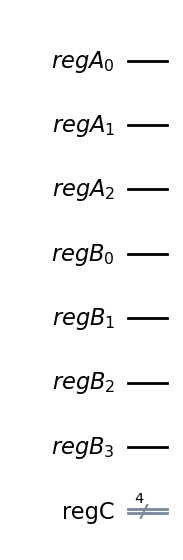

In [30]:
if len(firstBinaryNumber) < len(secondBinaryNumber):
    firstBinaryNumber, secondBinaryNumber = secondBinaryNumber, firstBinaryNumber

secondBinaryNumber = "0" * (len(firstBinaryNumber) - len(secondBinaryNumber)) + secondBinaryNumber
maxInputLength = len(firstBinaryNumber)

regA = QuantumRegister(maxInputLength, "regA")
regB = QuantumRegister(maxInputLength+1, "regB")
regC = ClassicalRegister(maxInputLength + 1, "regC")
qc = QuantumCircuit(regA, regB, regC, name="qc")

qc.draw("mpl")

- **`regA`** (Quantum Register, `maxInputLength` qubits)
  - This register stores the first binary number.
  - Each qubit represents a bit of the input, initialized in the `|0⟩` or `|1⟩` state based on the binary number.
  
- **`regB`** (Quantum Register, `maxInputLength + 1` qubits)
  - This register stores the second binary number and also serves as the output register.
  - The extra qubit (`+1`) is necessary to accommodate possible carry-over in the final sum.
  
- **`regC`** (Classical Register, `maxInputLength + 1` bits)
  - This is a classical register used to store the final measured result.
  - After running the quantum computation, the output is measured and saved into `regC`.

Right now, the registers are empty. So we need to put our data in them.
Because all of the individual qbits are set to |0⟩ as default we just need to
use the NOT gate on the qbits that we want to flip into |1⟩.

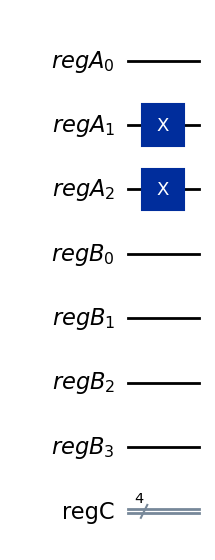

In [31]:
for idx, val in enumerate(firstBinaryNumber):
    if val == "1":
        qc.x(regA[maxInputLength - (idx + 1)])
for idx, val in enumerate(secondBinaryNumber):
    if val == "1":
        qc.x(regB[maxInputLength - (idx + 1)])
qc.draw("mpl")

### 3.2 Addition circuit

#### 3.2.1 QFT
##### Outer Loop (`target` qubits in `regB`)

- The loop iterates **backward** over all qubits in `regB` (from highest to lowest index).
- A **Hadamard gate (`H`)** is applied to each `target` qubit, transforming it into an **equal superposition** of `|0⟩` and `|1⟩` states.
- This step is **crucial** for preparing the qubits to encode phase relationships.

##### Inner Loop (`control` qubits in `regB`)

- For each `target` qubit, a nested loop iterates **backward** over all preceding qubits (`control`).
- The loop applies a **controlled-phase (`cp`) gate** between the `target` and each `control` qubit.
- The controlled phase shift `λ` is computed as $\pi$ divided by the 2 to the power of the diference between the indexes `target` and `control`

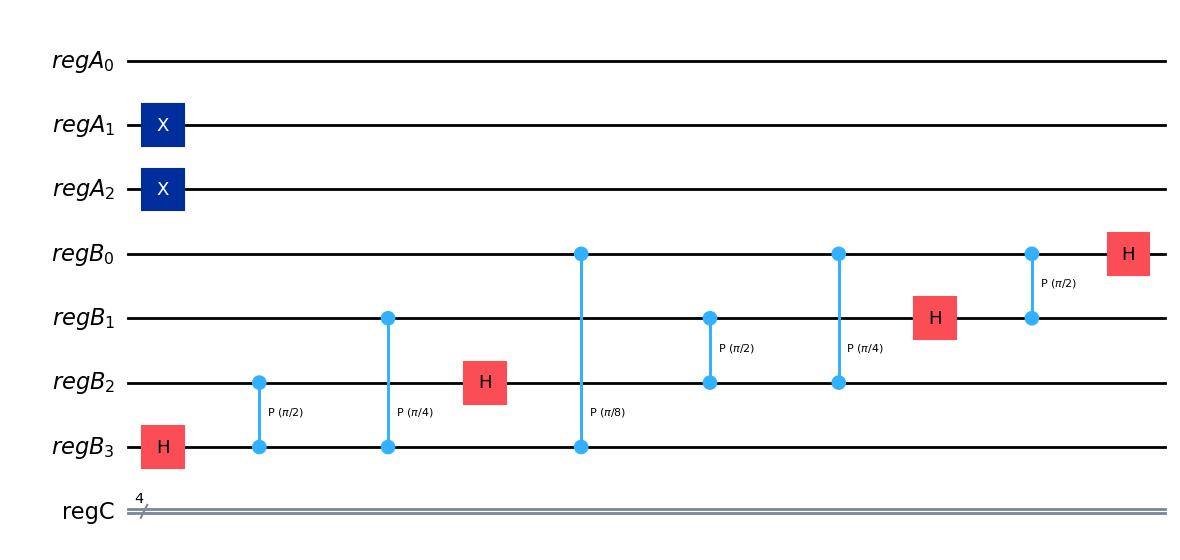

In [ ]:
for target in range(maxInputLength, -1, -1):
    qc.h(regB[target])
    for control in range(target-1, -1, -1):
        qc.cp(math.pi*(2**(control-target)), regB[target], regB[control])
    qc.barrier()

qc.barrier()
qc.draw("mpl", plot_barriers=False)

#### 3.2.2 Addition
##### Outer Loop (target qubits from `regA`)

- The `target` qubit iterates over all qubits in `regA`. This represents the bits of the first operand in the addition process.
- These qubits will act as the control for phase additions.

##### Inner Loop (control qubits in `regB`)

- For each `target` qubit in `regA`, we iterate through the corresponding qubits in `regB` that will receive the phase shift.
- The range `maxInputLength + 1 - target` ensures that each qubit in `regA` only influences valid corresponding qubits in `regB`.
- The controlled phase shift `λ` is computed as $\pi$ divided by the 2 to the power of the index `control`


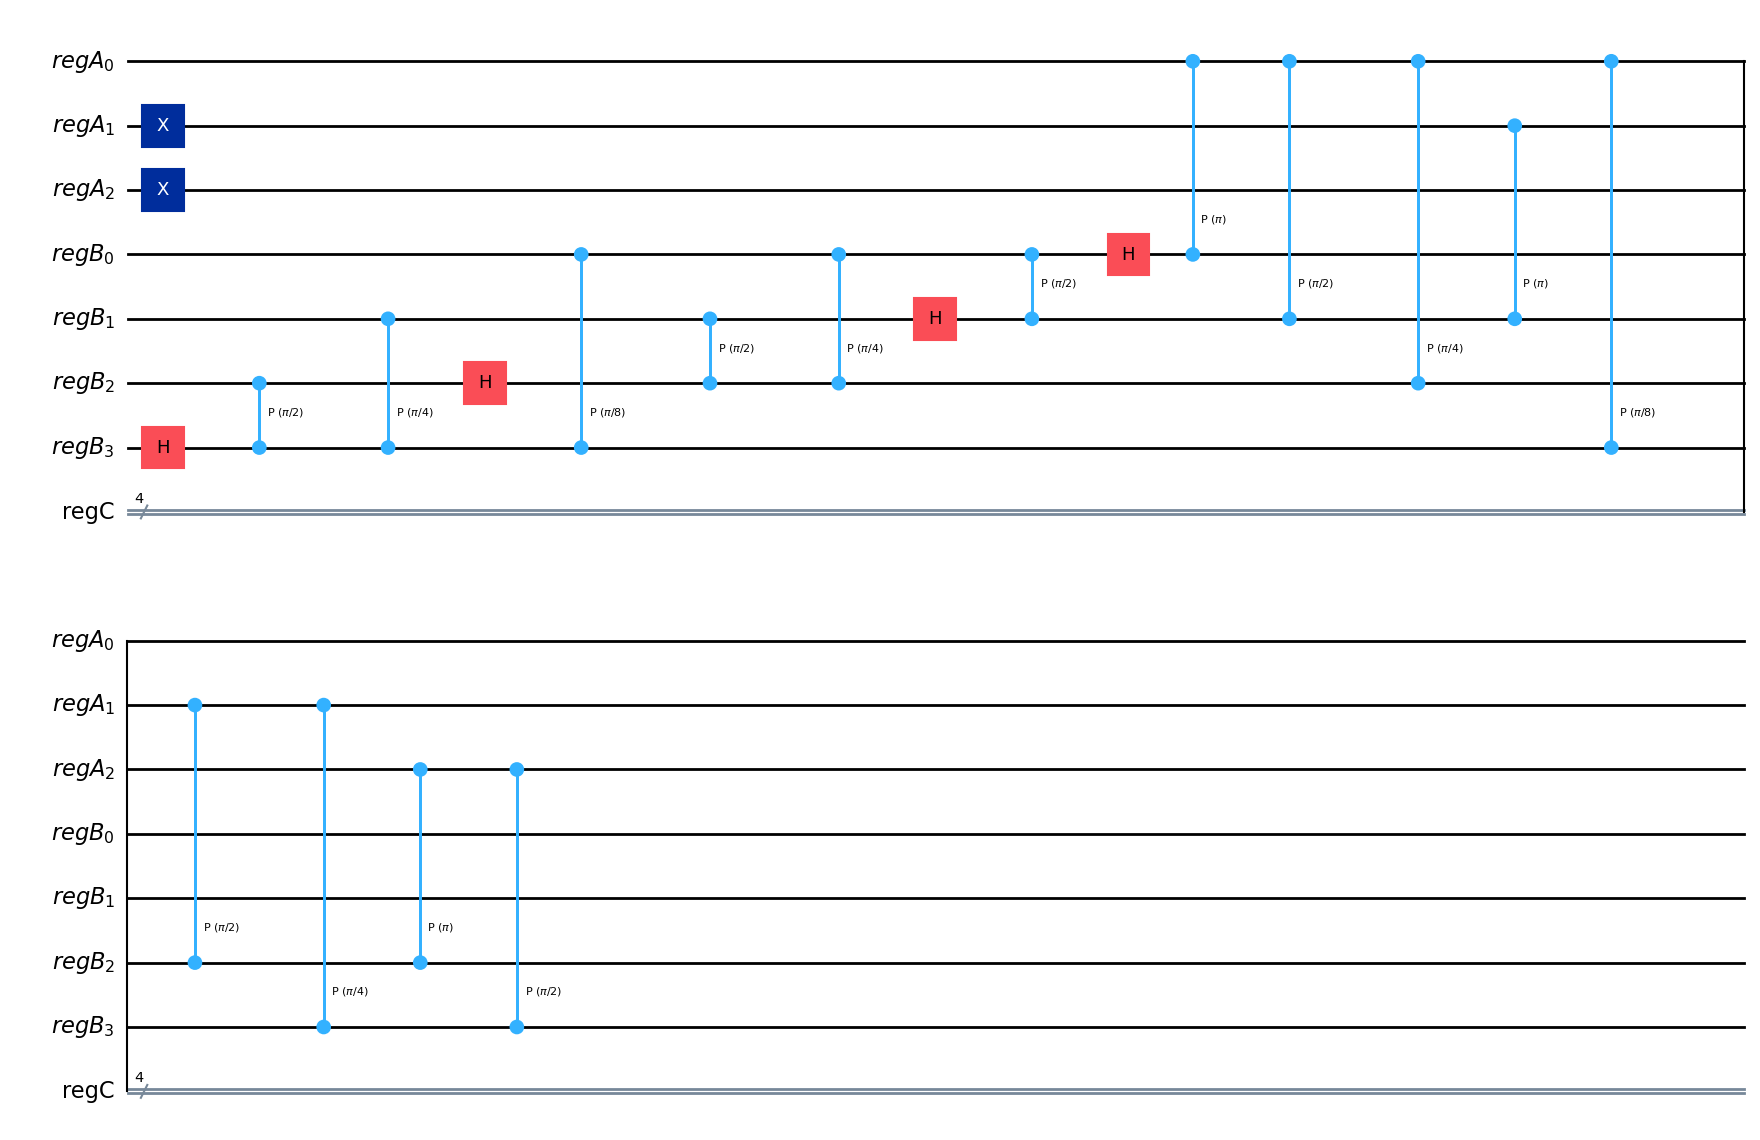

In [33]:
for target in range(maxInputLength):
    for control in range(maxInputLength + 1 - target):
        lam = math.pi / (2**control)
        qc.cp(lam, regA[target], regB[target+control])
qc.barrier()
qc.draw("mpl", plot_barriers=False)

#### 3.2.3 Inverse QFT
##### Outer Loop (`target` qubits in `regB`)

- The loop iterates over all qubits in `regB`, applying a **Hadamard gate (`H`)** to each qubit.
- The Hadamard gate creates an **equal superposition** of `|0⟩` and `|1⟩`, preparing the qubit for phase cancellation.

##### Inner Loop (`control` qubits in `regB`)

- For each `target` qubit, we iterate over **subsequent** qubits (`control` qubits) in `regB` to apply inverse phase shifts.
- The range starts from `target + 1` to `maxInputLength + 1`, ensuring that **higher-order qubits influence lower-order ones**.
- The controlled phase shift `λ` is computed as -$\pi$ divided by the 2 to the power of the diference between the indexes `target` and `control`.

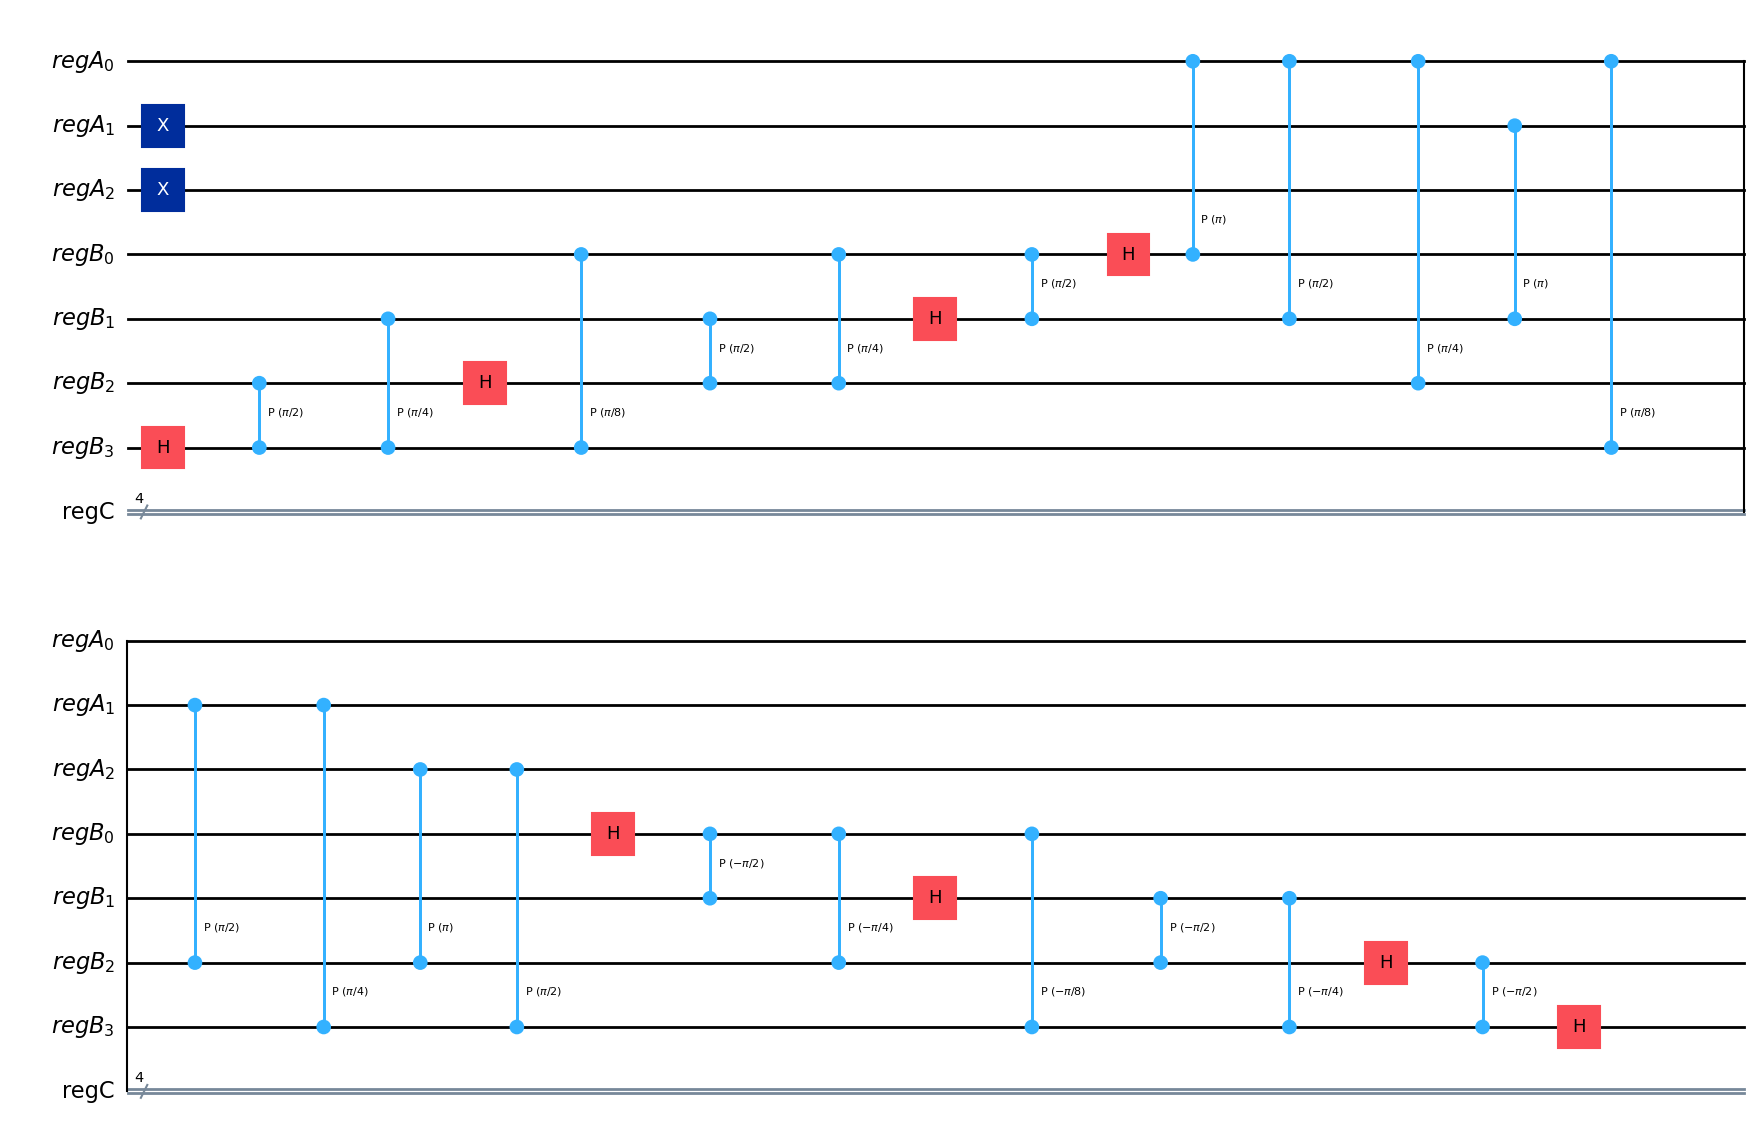

In [34]:
for target in range(maxInputLength + 1):
    qc.h(regB[target])
    for control in range(target+1, maxInputLength + 1):
        qc.cp(-math.pi/(2**(control-target)), regB[control], regB[target])
qc.draw("mpl", plot_barriers=False)

Here are the variants that use built in functions in qiskit.

In [35]:
"""
# Decomposed to qfts
qc.append(QFT(maxInputLength + 1, do_swaps=False, name="qft").to_gate(), regB[:])
qc.barrier()

for j in range(maxInputLength):
    for k in range(maxInputLength + 1 - j):
         lam = math.pi / (2**k)
         qc.cp(lam, regA[j], regB[j+k])
qc.barrier()

qc.append(QFT(maxInputLength + 1, do_swaps=False, name="iqft").inverse().to_gate(), regB[:])
"""
# Prepared gate
#qc.append(DraperQFTAdder(maxInputLength+1), qargs=regA[:] + regB[:])

'\n# Decomposed to qfts\nqc.append(QFT(maxInputLength + 1, do_swaps=False, name="qft").to_gate(), regB[:])\nqc.barrier()\n\nfor j in range(maxInputLength):\n    for k in range(maxInputLength + 1 - j):\n         lam = math.pi / (2**k)\n         qc.cp(lam, regA[j], regB[j+k])\nqc.barrier()\n\nqc.append(QFT(maxInputLength + 1, do_swaps=False, name="iqft").inverse().to_gate(), regB[:])\n'

### 3.3  Measuring and running the simulation
Now that the circuit is fully constructed, we need to simulate it to obtain the results. We measure the `regB` in to `regC`, initialize a quantum simulator, compile our circuit for execution, and let it compute the result.

0110


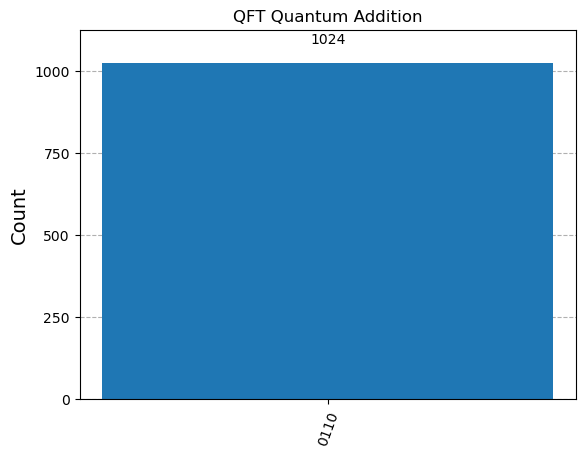

In [36]:
qc.measure(regB, regC)

simulator = AerSimulator()
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)

print(max(counts, key=counts.get))
plot_histogram(counts, title='QFT Quantum Addition')